In [2]:
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from sklearn.feature_extraction.text import CountVectorizer
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore") 
from sklearn.metrics import confusion_matrix
import numpy as np

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
df = pd.read_csv('/content/drive/MyDrive/Soft_Com/Assignment_3/Dataset_2.csv',encoding='latin1')
df.sample(10)

,text,polarity
8861,is it normal to have or having a feeling like ...,1
4456,@kabutar I was auditioning as a *cough* dancer...,0
563,Had a great early morning workout!! Getting re...,0
6475,@MissMillions yes it's a beautiful sunday over...,0
4612,@WTFKatie the video's done I can't get the li...,0
8220,Only did it to set up an event for my birthday...,1
3487,morning today is gonna be a twitter-less day ...,0
8840,@krassenstein Honestly I think it was #Trump's...,1
2095,@tobint eat something just not pancakes,0
891,"going for a bath, gotta start microcontrollers...",0


In [6]:
df.groupby('polarity').size()

polarity
0    8000
1    2314
dtype: int64

Text(0.5, 0, 'text')

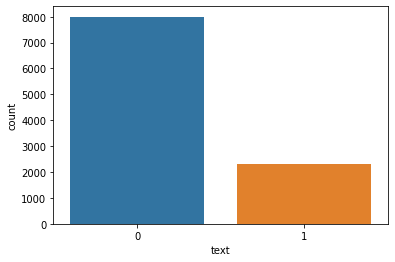

In [7]:

sns.countplot(df.polarity)
plt.xlabel('text')

In [8]:
class Sequences(Dataset):
    def __init__(self, data):
        self.vectorizer = CountVectorizer(stop_words='english')
        self.sequences = self.vectorizer.fit_transform(data.text.tolist())
        self.labels = data.polarity.tolist()
        self.token2idx = self.vectorizer.vocabulary_
        self.idx2token = {idx: token for token, idx in self.token2idx.items()}
    
    def __getitem__(self, i):
        return self.sequences[i, :].toarray(), self.labels[i]
    
    def __len__(self):
        return self.sequences.shape[0]

In [9]:
batch_size = 32

In [10]:
dataset = Sequences(df)
train_size = int(len(dataset)*.8);
test_size = int(len(dataset) - train_size);
train_dataset, test_dataset = torch.utils.data.random_split(dataset,[train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [11]:
len(dataset.token2idx)

22212

In [12]:
input_size = len(dataset.token2idx)
hidden_size = 128
num_classes = 2
num_layers = 5
learning_rate = 0.01
sequence_length = 1
num_epochs = 20

In [13]:
print(len(train_dataset))
print(len(test_dataset))

8251
2063


In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [15]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.D = 2
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True,nonlinearity='tanh', bidirectional=True)
        self.fc = nn.Linear(self.D*hidden_size, num_classes)
    
    def forward(self, x):
        # Set initial hidden and cell states 
        h0 = torch.zeros(self.D*self.num_layers, x.size(0), self.hidden_size).to(device) 
        
        # Forward propagate LSTM
        out, _ = self.rnn(x, h0) 
        h0 = torch.zeros(self.D*self.num_layers, out.size(0), self.hidden_size).to(device) 
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

In [16]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [18]:
# Train the model
y_pred = []
y_test = []
iter = []
losses = []
itr = 0
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (tweets, labels) in enumerate(train_loader):
        tweets = tweets.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        tweets = torch.tensor(tweets, dtype = torch.float)
        # Forward pass
        outputs = model(tweets)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        itr = itr + 1
        if (i+1) % 10 == 0:
            iter.append(itr)
            losses.append(loss.item())
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
        
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for tweets, labels in test_loader:
        tweets = tweets.reshape(-1, sequence_length, input_size).to(device)
        labels = labels.to(device)
        tweets = torch.tensor(tweets, dtype = torch.float)
        outputs = model(tweets)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_pred.extend(predicted)
        y_test.extend(labels)

    print('Test Accuracy of the model : {} %'.format(100 * correct / total)) 

# Save the model checkpoint
torch.save(model.state_dict(), 'model.ckpt')

Epoch [1/20], Step [10/258], Loss: 0.5774
Epoch [1/20], Step [20/258], Loss: 0.5957
Epoch [1/20], Step [30/258], Loss: 0.3770
Epoch [1/20], Step [40/258], Loss: 0.4155
Epoch [1/20], Step [50/258], Loss: 0.1348
Epoch [1/20], Step [60/258], Loss: 0.4683
Epoch [1/20], Step [70/258], Loss: 0.0910
Epoch [1/20], Step [80/258], Loss: 0.1804
Epoch [1/20], Step [90/258], Loss: 0.2423
Epoch [1/20], Step [100/258], Loss: 0.1690
Epoch [1/20], Step [110/258], Loss: 0.1433
Epoch [1/20], Step [120/258], Loss: 0.2897
Epoch [1/20], Step [130/258], Loss: 0.0455
Epoch [1/20], Step [140/258], Loss: 0.2296
Epoch [1/20], Step [150/258], Loss: 0.0472
Epoch [1/20], Step [160/258], Loss: 0.3406
Epoch [1/20], Step [170/258], Loss: 0.1958
Epoch [1/20], Step [180/258], Loss: 0.1760
Epoch [1/20], Step [190/258], Loss: 0.2256
Epoch [1/20], Step [200/258], Loss: 0.1998
Epoch [1/20], Step [210/258], Loss: 0.7353
Epoch [1/20], Step [220/258], Loss: 0.1308
Epoch [1/20], Step [230/258], Loss: 0.2579
Epoch [1/20], Step [

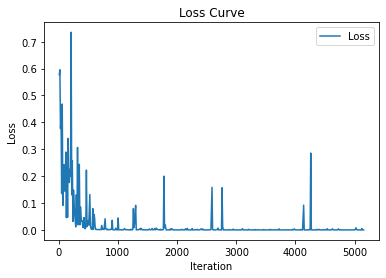

In [19]:
plt.plot(iter, losses, label='Loss')
plt.title('Loss Curve')
plt.ylabel('Loss')
plt.xlabel('Iteration')
plt.legend()

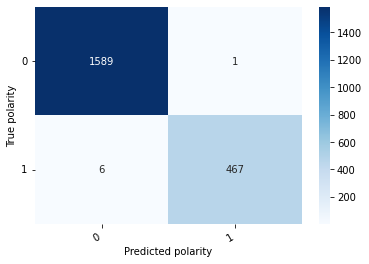

In [20]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True polarity')
  plt.xlabel('Predicted polarity');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=[0,1], columns=[0,1])
show_confusion_matrix(df_cm)


In [21]:
tp = 0
tn = 0
fp = 0
fn = 0
for i in range(len(y_test)):
  tn += ((y_pred[i] == 0) &  (y_test[i] == 0)).float()
  tp += ((y_pred[i] == 1) &  (y_test[i] == 1)).float()
  fn += ((y_pred[i] == 0) &  (y_test[i] == 1)).float()
  fp += ((y_pred[i] == 1) &  (y_test[i] == 0)).float()

print(tn, ' ', fn, ' ', fp, ' ', tp)

tensor(1589.)   tensor(6.)   tensor(1.)   tensor(467.)


In [22]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1_score = 2* ((precision*recall)/(precision+recall))

In [23]:
print('Precision: ', precision.item(), 'Recall: ', recall.item(),  'F1_score: ', f1_score.item())

Precision:  0.997863233089447 Recall:  0.9873149991035461 F1_score:  0.9925611019134521
